In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML, Image

# Warning: proteinsolver is very buggy!
# You may need to edit files manually if you get any errors.
import proteinsolver
# Warning: kmbio is buggy too!
# Some of the imports need to be redirected to biopython
import Bio
from kmbio import PDB
from kmtools import sci_tools, structure_tools

import project_path

from lib import viz
from lib.schema import Protein, ProteinSolverResult, Session

_ColormakerRegistry()

In [3]:
session = Session()

In [4]:
ids = [x[0] for x in session.query(Protein.pdb_id).all()]

In [5]:
p = session.query(Protein).filter_by(pdb_id=ids[0]).first()

In [6]:
print("Sequence:", p.sequence)
print("Length:", p.length)
print("Family:", p.family)
print("Contacts:", p.contacts())
p.render()

Sequence: LPLPEGWEEARDFDGKVYYIDHRNRTTSWIDPRDRYTKPLTFADCISDELPLGWEEAYDPQVGDYFIDHNTKTTQIEDPRVQWRREQEH
Length: 89
Family: WW
Contacts: [(11, 28), (47, 88), (58, 75), (39, 43)]


/home/home3/fny/.anaconda3/envs/proteinsolver/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2365.
  PDBConstructionWarning,
/home/home3/fny/.anaconda3/envs/proteinsolver/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain U is discontinuous at line 2393.
  PDBConstructionWarning,
/home/home3/fny/.anaconda3/envs/proteinsolver/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2413.
  PDBConstructionWarning,
/home/home3/fny/.anaconda3/envs/proteinsolver/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain U is discontinuous at line 2467.
  PDBConstructionWarning,


NGLWidget()

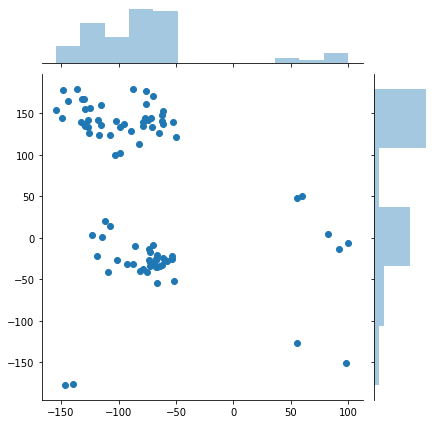

In [7]:
p.rama_plot()

In [8]:
def find_protein_result(prot):
    session = Session()
    return session.query(ProteinSolverResult).filter_by(pdb_id=prot.pdb_id).first()

In [9]:
res = find_protein_result(p)

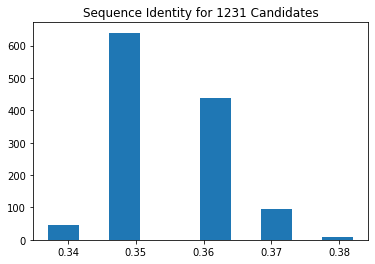

In [10]:
plt.hist(res.seq_identities)
plt.title(f"Sequence Identity for {len(res.seq_identities)} Candidates")
plt.show()

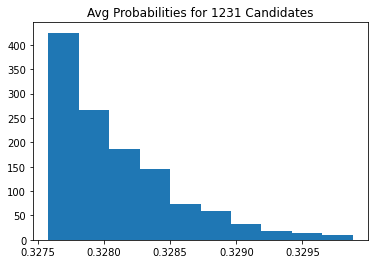

In [11]:
plt.hist(np.exp(res.log_prob_avgs))
plt.title(f"Avg Probabilities for {len(res.log_prob_avgs)} Candidates")
plt.show()

Wild type, Generated - Wild Type, Generated, Wild Type - Generated, Wild Type


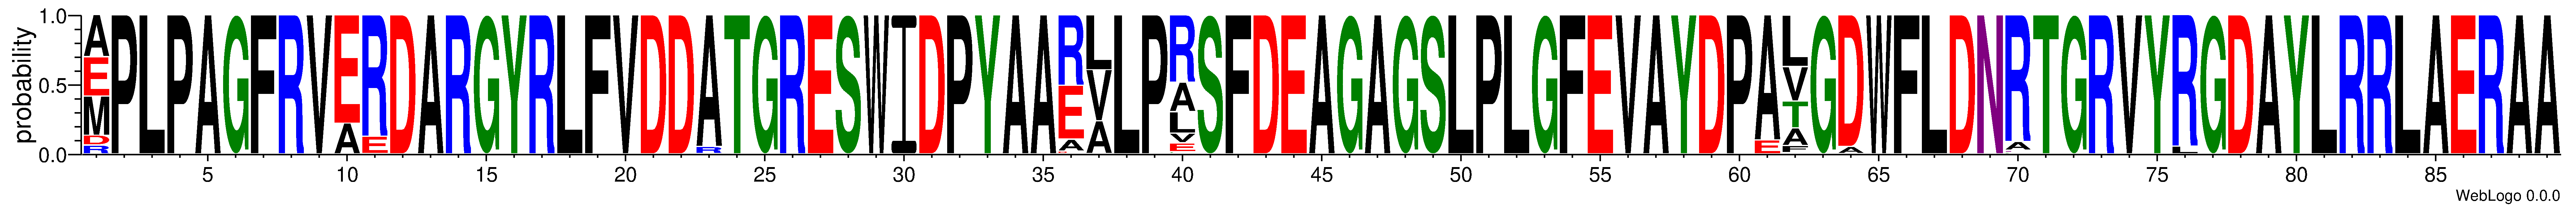

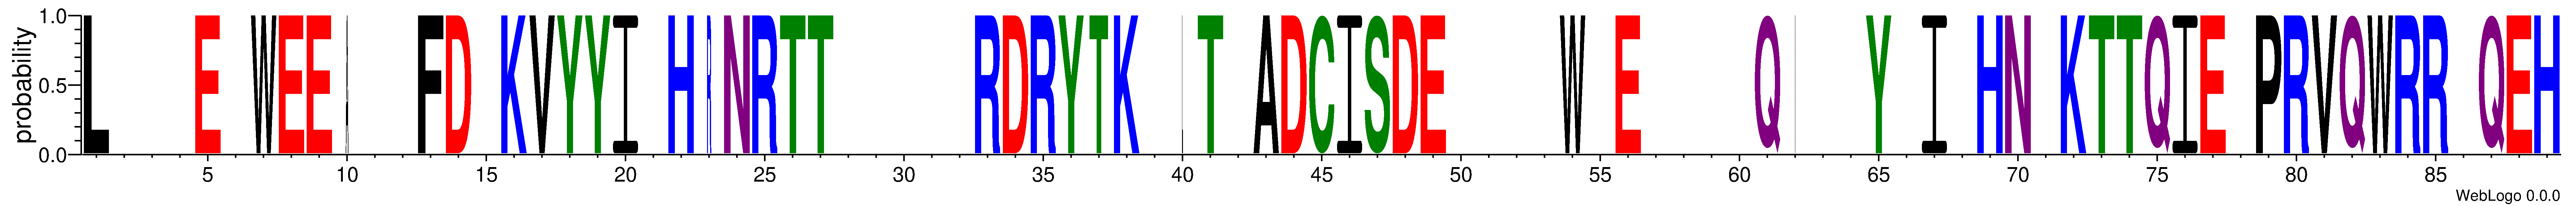

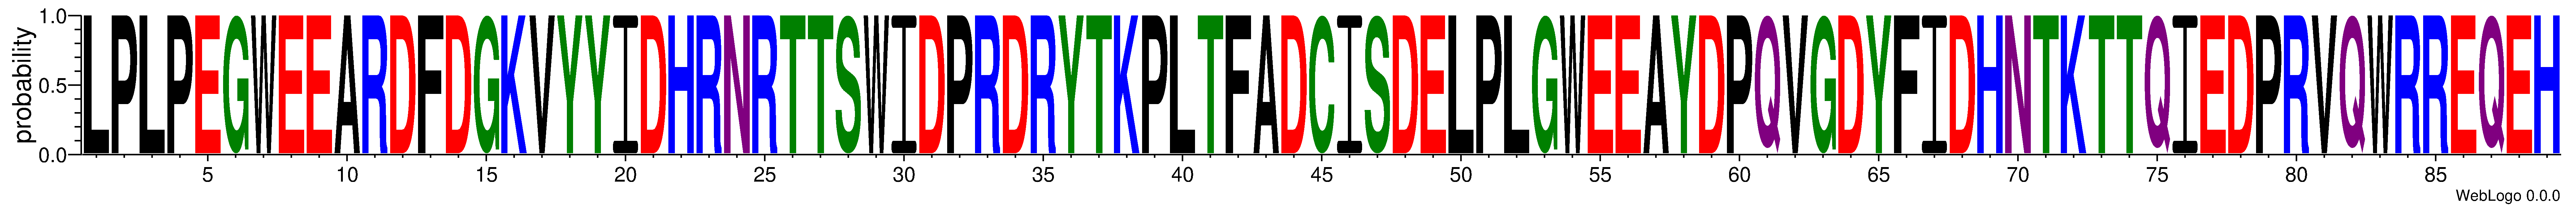

[(11, 28), (47, 88), (58, 75), (39, 43)]

In [12]:
def remove_dups(a, b):
    seqs = []
    for seqb in b:
        lseqb = list(seqb)            
        for seqa in a:
            for i in range(len(a[0])):
                if lseqb[i] == seqa[i]:
                    lseqb[i] = ' '
            seqs.append(''.join(lseqb))
    return seqs

print("Wild type, Generated - Wild Type, Generated, Wild Type - Generated, Wild Type")

display(
    HTML('<b>Generated</b>'),
    viz.render_weblogo(res.sequences),
    HTML('<b>Wild Type - Generated</b>'),
    viz.render_weblogo(remove_dups(res.sequences, [p.sequence])),
    HTML('<b>Wild Type</b>'),
    viz.render_weblogo([p.sequence]),
)

p.contacts()

In [13]:
results = session.query(ProteinSolverResult).all()

for result in results:
    if len(result.log_prob_avgs) > 0:
        result.max_prob_avg = min(result.log_prob_avgs)

result_summary = pd.DataFrame({
    'pdb_id': [r.pdb_id for r in results if len(r.log_prob_avgs) > 0],
    'max_prob_avg': [np.exp(r.max_prob_avg) for r in results if len(r.log_prob_avgs) > 0],
    'max_seq_id': [max(r.seq_identities) for r in results if len(r.log_prob_avgs) > 0]
})
ids_fams = session.query(Protein.pdb_id, Protein.family, Protein.length).all()
ids_fams_df = pd.DataFrame(ids_fams, columns=["pdb_id", "family", "length"])
merged = pd.merge(ids_fams_df, result_summary, on="pdb_id", how="inner")

summary = merged.groupby(['family'], as_index=False).agg({'pdb_id': 'count', 'max_seq_id':['mean','std'], 'length': ['mean', 'std']})
summary

family pdb_id max_seq_id                length           
                  count       mean       std        mean        std
0            PDZ    156   0.393727  0.058179   98.666667  11.510631
1            POZ     93   0.372645  0.046797  106.440860  18.367305
2            SH2    181   0.354188  0.099247  100.767956  20.273444
3            SH3    302   0.343808  0.071155   64.347682  11.879586
4             WW    132   0.338549  0.089289   61.878788  33.953500
5  histone-folds     75   0.329927  0.038842   93.600000  10.993856
6    thioredoxin    301   0.396327  0.063923  105.777409  10.802482